In [394]:
%load_ext pycodestyle_magic
%pycodestyle_on
%matplotlib inline

In [345]:
import sqlite3
import re
import string
import numpy as np
import pandas as pd
import scipy.stats

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (accuracy_score, r2_score,
                             confusion_matrix, f1_score)
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams.update({'font.size': 18,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12,
                     'ytick.alignment': 'center'
                     })

### Pull data out of sqlite database
Use the `get_data.sh` script to download the data. Test for duplicate entries, caused by reviews with more than one genre.

In [310]:
conn = sqlite3.connect('database.sqlite')

query = """
SELECT r.reviewid,
       r.title,
       r.artist,
       r.score,
       r.best_new_music,
       r.author,
       r.pub_date,
       c.content,
       g.genre
FROM reviews r
JOIN genres g ON g.reviewid = r.reviewid
JOIN content c ON c.reviewid = r.reviewid
WHERE g.genre IN ('rock', 'rap', 'experimental', 'pop/r&b', 'electronic')
ORDER BY pub_date;
"""

df = pd.read_sql(query, conn)
print(df['genre'].value_counts())

test_dups = df['reviewid'].value_counts()
print(test_dups[test_dups != 1].shape)

### Disambiguate Genre
Assign reviews with multiple genre to the more "specific" one, with fewer reviews in general. Make sure no more reviews have dupicate entries.

In [311]:
genre_order = ['pop/r&b', 'rap', 'experimental', 'electronic', 'rock']
genre_type = pd.api.types.CategoricalDtype(genre_order, ordered=True)
df['genre'] = pd.Series(df['genre'], dtype=genre_type)

df = df.sort_values('genre').groupby('reviewid').first()
df = pd.DataFrame(df.to_records())
print(df['genre'].value_counts())

test_dups = df['reviewid'].value_counts()
print(test_dups[test_dups != 1].shape)

### Create the memorizing stemmer
Later, we will want to go back and see which words correspond to particular stems. This class stems the words with the snowball stemmer from NLTK, and then keeps track of which words got assigned to that stem, as well as how many times.

In [322]:
class MemorizingSnowballStemmer():
    """Stem words using the snowball stemmer, remembering
    which words were assigned to each stem."""

    def __init__(self, lang, **kwargs):
        """Pass arguments onto SnowballStemmer, and
        initialize the memory dictionary."""
        self._stemmer = SnowballStemmer(lang, **kwargs)
        self._mem = {}

    def stem(self, word):
        "Stem words using SnowballStemmer, and update the memory dictionary."
        stemmed_word = self._stemmer.stem(word)
        if stemmed_word in self._mem:
            if word not in self._mem[stemmed_word]:
                self._mem[stemmed_word][word] = 1
            else:
                self._mem[stemmed_word][word] += 1
        else:
            self._mem[stemmed_word] = {word: 1}
        return stemmed_word

    def unstem(self, stem):
        "Return all words assigned to a particular stem."
        if stem in self._mem:
            return self._mem[stem]
        else:
            return {}

    def unstem_most_common(self, stem):
        "Return the word most commonly assigned to a particular stem."
        if stem in self._mem:
            freq_dict = self._mem[stem]
            return sorted(freq_dict, key=freq_dict.get, reverse=True)[0]

### Stem the reviews using our memorizing stemmer

In [347]:
stemmer = MemorizingSnowballStemmer('english', ignore_stopwords=True)
strip_punct = str.maketrans('', '', string.punctuation)


def stem_text(s):
    "Stem each word in s, then join the stems together with spaces."
    return ' '.join(
        [stemmer.stem(word) for word in
         word_tokenize(s.translate(strip_punct))])


df['content_stemmed'] = df['content'].apply(stem_text)

### Vectorize the stemmed text
We will use the tfidf vectorization for PCA/SVM classification as well as L1 feature selection, and the count vectorization for Naive Bayes.

In [348]:
vect_tfidf = TfidfVectorizer(stop_words='english', min_df=5)
words_tfidf = vect_tfidf.fit_transform(df['content_stemmed'])
print(words_tfidf.shape)

In [349]:
vect_count = CountVectorizer(stop_words='english', min_df=5)
words_count = vect_count.fit_transform(df['content_stemmed'])
print(words_count.shape)

### Select target columns, and create testing and training data sets.

In [352]:
target_columns = ['score', 'best_new_music', 'genre']
targets = df[target_columns]
words_tfidf_train, words_tfidf_test, \
    words_count_train, words_count_test, \
    targets_train, targets_test \
    = train_test_split(words_tfidf, words_count, targets, random_state=420)

### Classify the data with PCA and a Linear SVC.

In [353]:
pca = PCA(n_components=10)
pca_features = pca.fit_transform(words_tfidf_train.toarray())

clf_svm = LinearSVC()
clf_svm.fit(pca_features, targets_train['genre'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Plots of PCA/SVC data.
In the plots, we can see that reviews of Rap albums are well seperated from the other groups, but the rest are not really seperable. For clarity, R&B and Experimental albums are not shown, but they are mixed with the Electronic and Rock albums. A trend in score is not really visible either.

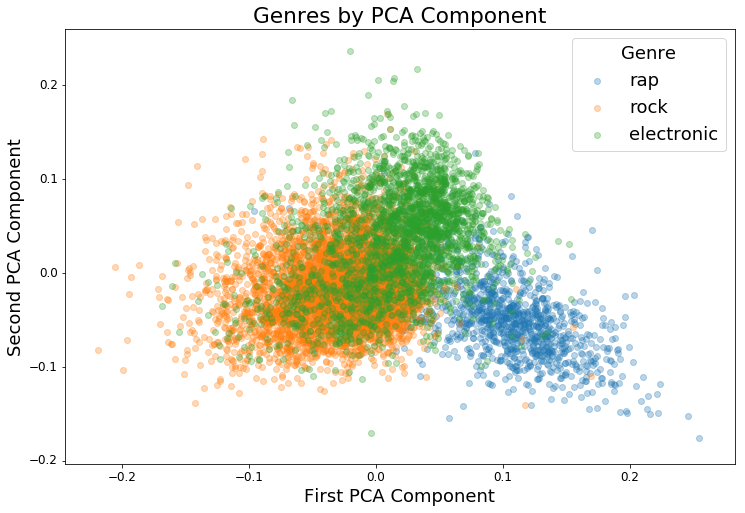

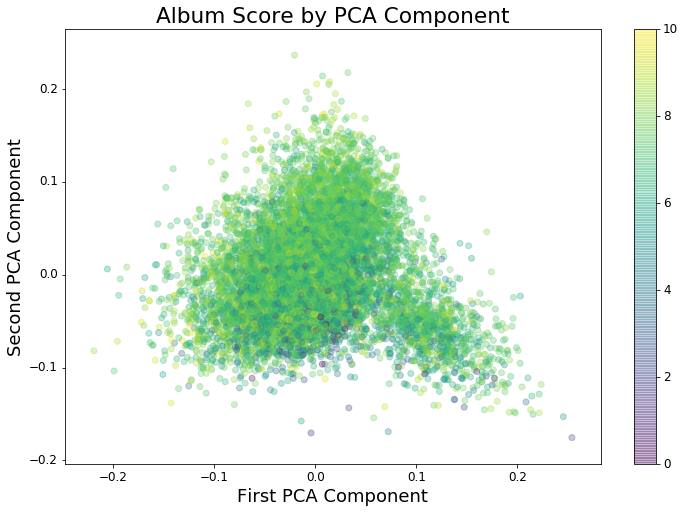

In [356]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

for genre in ['rap', 'rock', 'electronic']:
    genre_selector = targets_train['genre'] == genre
    ax.scatter(pca_features[:, 0][genre_selector],
               pca_features[:, 1][genre_selector], alpha=0.3, label=genre)

ax.legend(title="Genre")
ax.set_title("Genres by PCA Component")
ax.set_xlabel("First PCA Component")
ax.set_ylabel("Second PCA Component")
plt.savefig('genres_by_pca.pdf')

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
sc = ax.scatter(pca_features[:, 0], pca_features[:, 1],
                alpha=0.3, c=targets_train['score'], cmap='viridis')
ax.set_title("Album Score by PCA Component")
ax.set_xlabel("First PCA Component")
ax.set_ylabel("Second PCA Component")
plt.colorbar(sc)
plt.savefig('score_by_pca.pdf')

### Confusion Matrix for SVM/LVC
As suggested above, this classifier does a decent job on determining rap from non-rap, but otherwise has a bias towards classifying everythin which is not rap as rock.

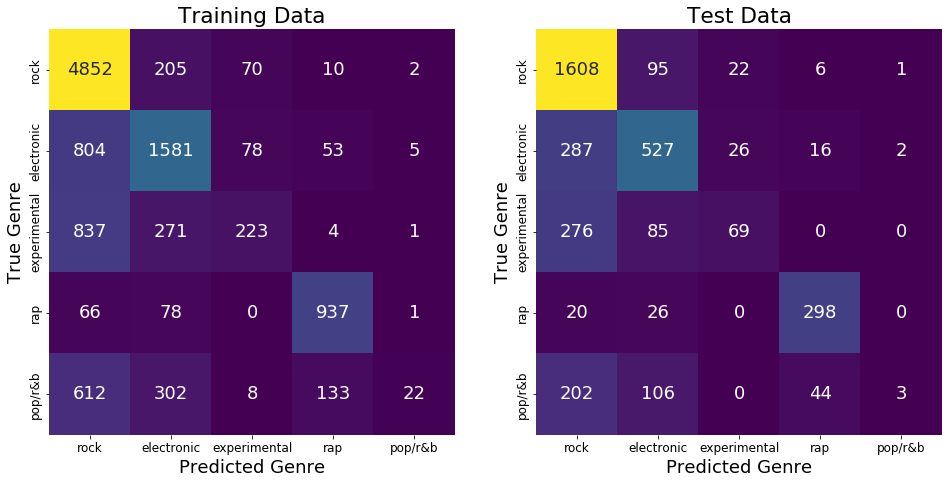

In [361]:
genre_labels = list(reversed(genre_order))

pred_train = clf_svm.predict(
    pca.transform(words_tfidf_train.toarray()))
pred_test = clf_svm.predict(
    pca.transform(words_tfidf_test.toarray()))

print('Training Accuracy: {}'.format(
    accuracy_score(targets_train['genre'], pred_train)))
print('Test Accuracy: {}'.format(
    accuracy_score(targets_test['genre'], pred_test)))
print('')
print('Training f1: {}'.format(
    f1_score(targets_train['genre'], pred_train,
             average=None, labels=genre_labels)))
print('Test f1: {}'.format(
    f1_score(targets_test['genre'], pred_test,
             average=None, labels=genre_labels)))

conf_mat_train = confusion_matrix(targets_train['genre'],
                                  pred_train, genre_labels)
conf_mat_test = confusion_matrix(targets_test['genre'],
                                 pred_test, genre_labels)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(conf_mat_train, ax=axs[0], annot=True, square=True,
            cmap='viridis', cbar=False, fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[0].set_title('Training Data')
axs[0].set_xlabel('Predicted Genre')
axs[0].set_ylabel('True Genre')

sns.heatmap(conf_mat_test, ax=axs[1], annot=True, square=True,
            cmap='viridis', cbar=False, fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[1].set_title('Test Data')
axs[1].set_xlabel('Predicted Genre')
axs[1].set_ylabel('True Genre')

plt.savefig('class_svm.pdf')

### Classify Genre with Naive Bayes

In [362]:
clf_nb = BernoulliNB()
clf_nb.fit(words_count_train, targets_train['genre'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

### Confusion Matrix using Naive Bayes

The classifier is still best at seperating rap from non-rap, but the distinction among the non-rap genres is much more well established.

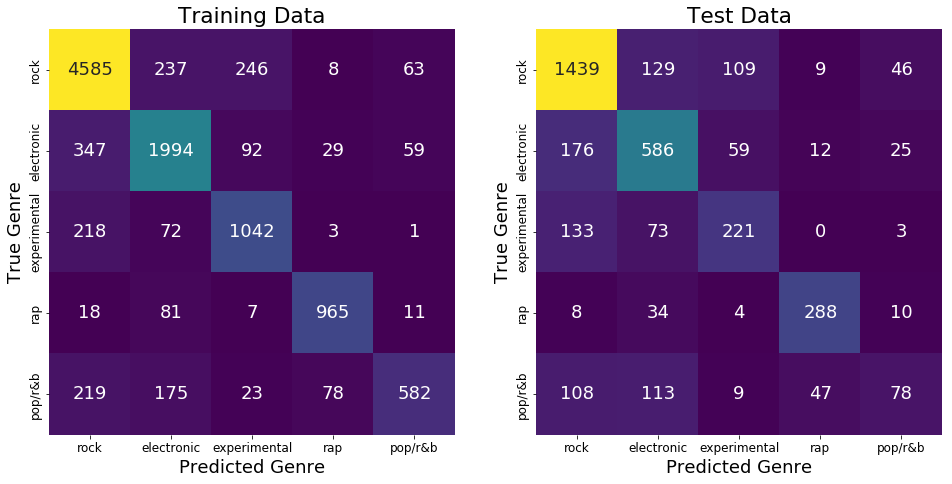

In [364]:
genre_labels = list(reversed(genre_order))

pred_train = clf_nb.predict(words_count_train.toarray())
pred_test = clf_nb.predict(words_count_test.toarray())

print('Training Accuracy: {}'.format(
    accuracy_score(targets_train['genre'], pred_train)))
print('Test Accuracy: {}'.format(
    accuracy_score(targets_test['genre'], pred_test)))
print('')
print('Training f1: {}'.format(
    f1_score(targets_train['genre'], pred_train,
             average=None, labels=genre_labels)))
print('Test f1: {}'.format(
    f1_score(targets_test['genre'], pred_test,
             average=None, labels=genre_labels)))

conf_mat_train = confusion_matrix(targets_train['genre'],
                                  pred_train, genre_labels)
conf_mat_test = confusion_matrix(targets_test['genre'],
                                 pred_test, genre_labels)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(conf_mat_train, ax=axs[0], annot=True, square=True,
            cmap='viridis', cbar=False,  fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[0].set_title('Training Data')
axs[0].set_xlabel('Predicted Genre')
axs[0].set_ylabel('True Genre')

sns.heatmap(conf_mat_test, ax=axs[1], annot=True, square=True,
            cmap='viridis', cbar=False,  fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[1].set_title('Test Data')
axs[1].set_xlabel('Predicted Genre')
axs[1].set_ylabel('True Genre')

plt.savefig('class_nb.pdf')

### Predicting important words for score using Lasso

Here, Lasso is used not only to try to predict album score from the review text, but to identify a compressed set of words with a strong influence on score. We then use the memorizing stemmer to see what english words these features correspond to.

### WARNING

This step took a long time and used most of the RAM on my machine, hence why the tfidf vectors are being cast to float32s.

In [384]:
reg = LassoLarsCV(cv=5, n_jobs=8)
reg.fit(words_tfidf_train.astype(np.float32).toarray(),
        targets_train['score'])

pred_train = reg.predict(words_tfidf_train)
pred_test = reg.predict(words_tfidf_test)
print("Train Score: {}".format(
    r2_score(targets_train['score'], pred_train)))
print("Test Score: {}".format(
    r2_score(targets_test['score'], pred_test)))

coef = reg.coef_
terms = vect_tfidf.inverse_transform(coef)

term_df = pd.DataFrame({
    'term': terms[0],
    'coef': coef[np.abs(coef) > 0]
}).sort_values('coef')

term_df['unstemmed'] = term_df['term'].apply(
    stemmer.unstem_most_common)

In [365]:
print("Number of regressors: {}".format(term_df.shape[0]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(term_df)
term_df.to_csv("terms_from_lasso.csv")

### PCA on the compressed features

Here we use PCA to see if we can construct some features which have some stronger correlation with album score. Perhaps there is, but I was not able to do better predicting score with these features than with the Lasso regression above.

In [366]:
score_selector = SelectFromModel(reg, prefit=True)
score_words_train = score_selector.transform(words_tfidf_train)
score_words_test = score_selector.transform(words_tfidf_test)

score_pca = PCA(n_components=10)
score_pca_features_train = score_pca.fit_transform(score_words_train.toarray())
score_pca_features_test = score_pca.transform(score_words_test.toarray())

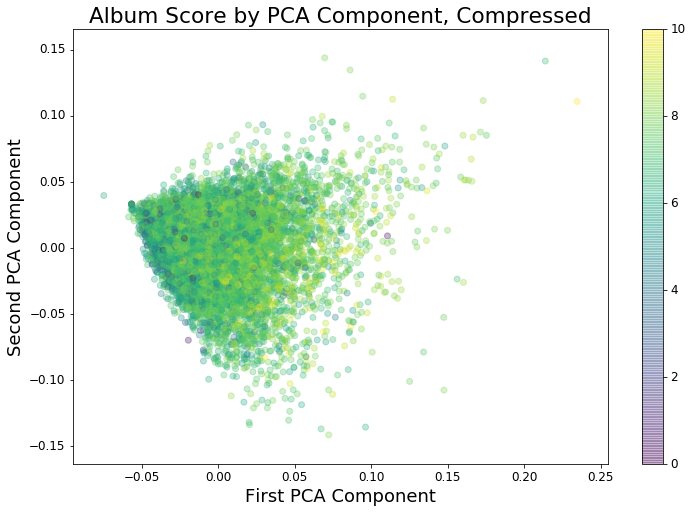

In [368]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
sc = ax.scatter(score_pca_features[:, 0], score_pca_features[:, 1],
                alpha=0.3, c=targets_train['score'], cmap='viridis')
ax.set_title("Album Score by PCA Component, Compressed")
ax.set_xlabel("First PCA Component")
ax.set_ylabel("Second PCA Component")
plt.colorbar(sc)
plt.savefig('compressed_score_by_pca.pdf')

### Find reviews with a particular term, for reference.

In [371]:
def find_term(df, t):
    "Select entries from our data that contain a particular stem."
    select = df['content_stemmed'].str.contains(t)
    return df[select]


test_df = find_term(df, 'insipid')

print(test_df)

### Looking for the 'Sophomore Slump'

Conventional wisdom holds that many bands tend to drop in quality on their second album vs. their first. Here we use the data to see if there is any evidence for this. First, a new data frame is constructed cointaining bands which have three or more releases.

In [386]:
select_artist = df.groupby('artist').count()['reviewid'] >= 3

scores_df = pd.DataFrame({
    'first_album': df.sort_values('pub_date').groupby('artist')
                     .first()[select_artist]['score'],
    'second_album': df.sort_values('pub_date').groupby('artist')
                     .nth(1)[select_artist]['score'],
    'third_album': df.sort_values('pub_date').groupby('artist')
                     .nth(2)[select_artist]['score'],
})

/home/tinsmancb/.virtualenvs/blog_post-Auhn-f79/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/tinsmancb/.virtualenvs/blog_post-Auhn-f79/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


The distribution of scores is plotted below, with the mean score. Some jitter is added to deal with quantization in the scores. Second albums have a lower mean than first albums, but is it significantly lower?

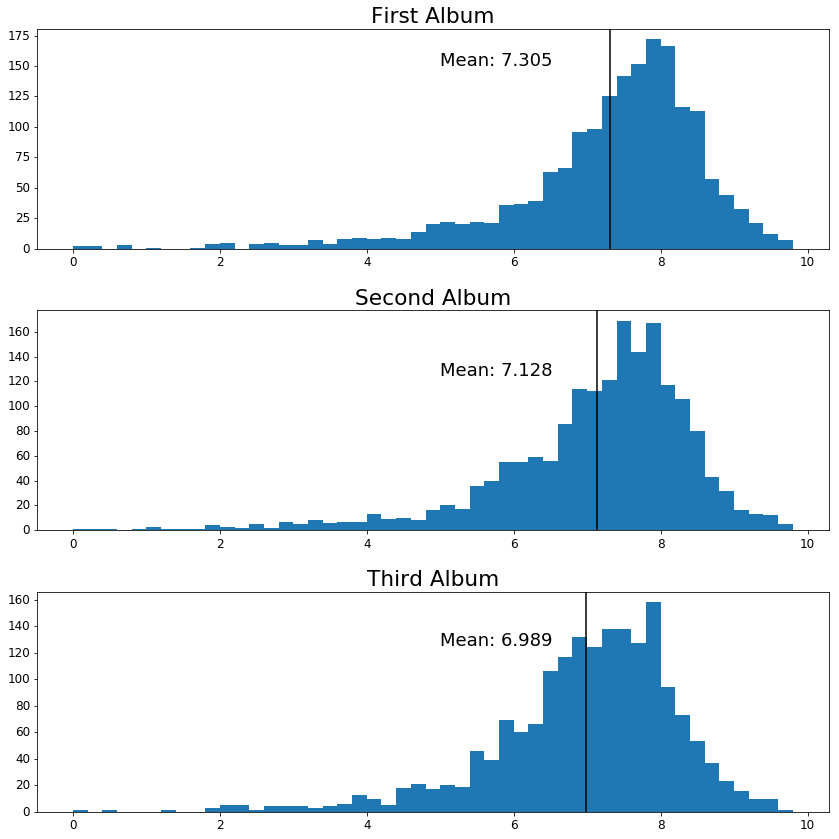

In [387]:
jitter = (np.random.rand(*scores_df.first_album.shape)-.5)/100

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

bins = np.arange(0, 10, 0.2)
axs[0].hist(scores_df['first_album']+jitter, bins=bins)
first_mean = scores_df['first_album'].mean()
axs[0].axvline(first_mean, c='k')
axs[0].set_title('First Album')
axs[0].annotate('Mean: {:.3f}'.format(first_mean), (5.0, 150))

axs[1].hist(scores_df['second_album']+jitter, bins=bins)
second_mean = scores_df['second_album'].mean()
axs[1].axvline(scores_df['second_album'].mean(), c='k')
axs[1].set_title('Second Album')
axs[1].annotate('Mean: {:.3f}'.format(second_mean), (5.0, 125))

axs[2].hist(scores_df['third_album']+jitter, bins=bins)
third_mean = scores_df['third_album'].mean()
axs[2].axvline(scores_df['third_album'].mean(), c='k')
axs[2].set_title('Third Album')
axs[2].annotate('Mean: {:.3f}'.format(third_mean), (5.0, 125))

plt.tight_layout()
plt.savefig('score_dist.pdf')

A t-test is used to determine if the distributions have different means. Based on the test, it does appear that the second score really is lower than the first on the whole. The third score is lower still, however the trend is not quite as strong.

In [395]:
print(scores_df['first_album'].mean())
print(scores_df['second_album'].mean())
print(scores_df['third_album'].mean())

print(scipy.stats.ttest_ind(scores_df['first_album'],
                            scores_df['second_album']))
print(scipy.stats.ttest_ind(scores_df['second_album'],
                            scores_df['third_album']))